In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import torch
import pandas as pd
import numpy as np
import requests
from PIL import Image
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from marketplace_assistant.config import RAW_IMAGE_FILE_DIR, PROCESSED_DATA_DIR

# Using Image-to-Text Model to Caption Images

https://github.com/vikhyat/moondream

In [3]:
model_id = "vikhyatk/moondream2"
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)
model = AutoModelForCausalLM.from_pretrained(
    model_id, trust_remote_code=True
).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)

A new version of the following files was downloaded from https://huggingface.co/vikhyatk/moondream2:
- configuration_moondream.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


mps


A new version of the following files was downloaded from https://huggingface.co/vikhyatk/moondream2:
- modeling_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/vikhyatk/moondream2:
- fourier_features.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/vikhyatk/moondream2:
- region_model.py
- fourier_features.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/vikhyatk/moondream2:
- vision_encoder.py
. Make sure to double-check they do not contai

In [4]:
marketplace_data_path = PROCESSED_DATA_DIR / "marketplace_data.csv"
marketplace_data = pd.read_csv(marketplace_data_path, )

marketplace_data.sample(5)

,brand,bullet_point,item_id,item_name,product_type,main_image_id,other_image_id,path
38066,Amazon Brand - Solimo,"Snug fit for Gionee X1, with perfect cut-outs ...",B0856B3D13,Amazon Brand - Solimo Designer Girl Boss On Wo...,CELLULAR_PHONE_CASE,71p0zPX-NLL,"['61+woWTqkwL', '61SE4RTPjdL']",23/232c9fe4.jpg
81479,AmazonBasics,"Valise de cabine de 50,8 cm avec coque extérie...",B07GNW1H5X,AmazonBasics Valise de cabine à motif géométri...,SUITCASE,81CvMu8ZVwL,"['81WSBZdLRhL', '71IH-Kw1osL', '81ZnATfhsWL', ...",e5/e5fdf679.jpg
2157,Movian,NaN,B08521MJDZ,GW-MAMIKO Lowboard 2944,HOME_FURNITURE_AND_DECOR,61Wbr+ay0rL,"['81iTX67spRL', '61I3X37YWdL', '91lCquP9IsL', ...",2e/2e471e27.jpg
54574,UMI,"Stoff - 100% seide, Hochwertigste Klasse-6A La...",B08F7MDBS6,UMI Seide Kissenbezug mit Reißverschluss 19 Mo...,HOME,51U7jPR-BVL,"['61ZFizePmxL', '81SvOuG3o6L', '518GQo4GkaL', ...",93/934d2e24.jpg
51180,Amazon Basics,Cuerpo de latón; estructura interna de acero; ...,B07GF4N27S,"AmazonBasics Perilla, esfera estándar, níquel ...",HARDWARE_HANDLE,61FYcdlVCcL,"['51zg2Z-TUoL', '61opL77hyPL', '71ybtz0l13L', ...",11/1149799d.jpg


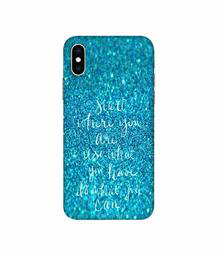

Amazon Brand - Solimo Designer Start were You are 3D Printed Hard Back Case Mobile Cover for Apple iPhone Xs Max


In [5]:
img_sample = marketplace_data.sample(1)
img_file = img_sample["path"].item()
img_desc = img_sample["item_name"].item()
img = Image.open(RAW_IMAGE_FILE_DIR / img_file)

display(img)
print(img_desc)


In [9]:
enc_image = model.encode_image(img)
print(model.answer_question(enc_image, "Write a caption that describes the object in the image in a concise manner.", tokenizer))

A phone case with a blue glittery texture features a quote in white cursive text: "Stay where you are, because you have a choice to make."


# Batched inference
Pass a list of image paths for batched inference

In [7]:
batch_size = 2
batch_sample = marketplace_data.sample(4)
data_len = len(batch_sample)

ans = []

for chunk in np.array_split(batch_sample, data_len / batch_size):
  chunk['full_path'] = str(RAW_IMAGE_FILE_DIR) + '/' + chunk['path'].astype(str)
  chunk_imgs = chunk['full_path'].tolist()
  chunk_imgs = [Image.open(name) for name in chunk_imgs]
  prompt = ["Write a caption that describes the object in the image in a concise manner."] * len(chunk)
  ans = ans + model.batch_answer(images=chunk_imgs, prompts = prompt, tokenizer = tokenizer)

batch_sample['ai_desc'] = ans

batch_sample

/Users/ashvath/anaconda3/envs/marketplace_assistant_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,brand,bullet_point,item_id,item_name,product_type,main_image_id,other_image_id,path,ai_desc
34694,365 by Whole Foods Market,Fabricado para ti por el mercado de alimentos ...,B07KZSQHGH,365 Everyday Value Probiotic Gummy 1 billón CF...,NUTRITIONAL_SUPPLEMENT,813MRwgO1AL,"['81AOjITZdSL', '81-psdLWFcL', '81xTin2se-L', ...",da/da13aed7.jpg,A clear glass bottle of 365 Kids' Gummy Probio...
146877,365 by Whole Foods Market,Brought to you by Whole Foods Market. The pac...,B074MFT17F,"365 Everyday Value, Crunchy Pretzel Sticks, 16 oz",GROCERY,81paz4ceOtL,"['61hRa1jnF7L', '91v+qWSvl4L', '41UKuAGgZdL', ...",60/60f8ed3b.jpg,"A bag of 365 crunchy pretzel sticks, weighing ..."
122803,Amazon Brand - Solimo,3D Printed Hard Back Case Mobile Cover for LG ...,B07TC63PX1,Amazon Brand - Solimo Designer Multicolor Drop...,CELLULAR_PHONE_CASE,71fhsA6wJEL,"['61oI69Yt4GL', '61Xce1Hq7DL', '81Mf+p7pKOL', ...",c3/c3242aec.jpg,A phone case features a vibrant abstract desig...
110159,UMI,NaN,B08F43KQTJ,UMI By Amazon Luxurious Velvet Decorative Cush...,HOME,71qXvJLzyTL,NaN,87/87c11ce5.jpg,Four identical white square pillows are arrang...


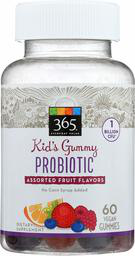

A clear glass bottle of 365 Kids' Gummy Probiotic Assorted Fruit Flavors gummy supplement, with a white cap and purple label, contains 60 gummy candies.


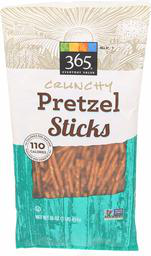

A bag of 365 crunchy pretzel sticks, weighing 110g, is displayed against a white background.


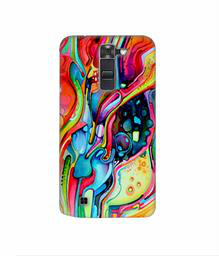

A phone case features a vibrant abstract design with a mix of red, blue, green, yellow, and orange colors, creating a dynamic and visually striking appearance.


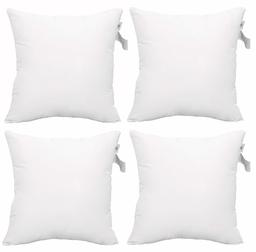

Four identical white square pillows are arranged in a 2x2 grid, each with a small gray tag attached to the right side.


In [8]:
for index, row in batch_sample.iterrows():
    image = Image.open(RAW_IMAGE_FILE_DIR / row["path"])
    display(image)
    print(row["ai_desc"])
    